# Seizure forecasting with EEG

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cPickle 
from matplotlib.collections import LineCollection
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN

In [4]:
import scipy.stats as ss
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier as Bagging

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.fftpack import fft 
import scipy
from sklearn.metrics import roc_curve
from sklearn.ensemble import GradientBoostingClassifier as GDB
%matplotlib inline

In [8]:
#set fold path
folder = './data/Patient_1 2/'

# Motivation

We want to classify between preictal (before seizure) and interictal (normal) EEG signals such that we can forecast seizures in epilepsy patients. This is help prevent severe consequences as early as possible.

# Dataset

We have interictal and preictal EEG data from 15 electrodes of one patients. 
https://www.kaggle.com/c/seizure-prediction/data

- Duration: 500mins of interictal, 180 minutes of preictal
- Sampling frequency: 5kHz
- Segment: one segment to be 4ms (20000 samples), in total 7500 interictal segments, 2700 preictal segments

# EEG Visualization

Segment the data to have 4ms each (20000 samples). Then we can have the frequency resolution to be 4 samples every 1Hz.

In [6]:
#Read in the eeg data and segment them
eeg = []
i = 0 
upper_lim = 200/5000. * 20000
for filename in os.listdir(folder):
     if "interictal" in filename:
        path = folder + filename
        i += 1
        struct = sio.loadmat(path, struct_as_record = False, squeeze_me = True) 
        eeg_temp = struct["interictal_segment_" + str(i)].data #read data from first electrode

        #segment egg data 
        eeg.append(eeg_temp) 

In [8]:
ch = 0 # particular channel to study 
y = eeg[0][ch,:20000]         # the signal, study channel 'ch'
L = len(y)            # signal length
fs = 5000              # sampling rate
T = L / float(fs)                # sample time
t= np.linspace(0,T,L)  # time vector

Now, we want to plot one 4ms segment with 15 channels.

20000 15


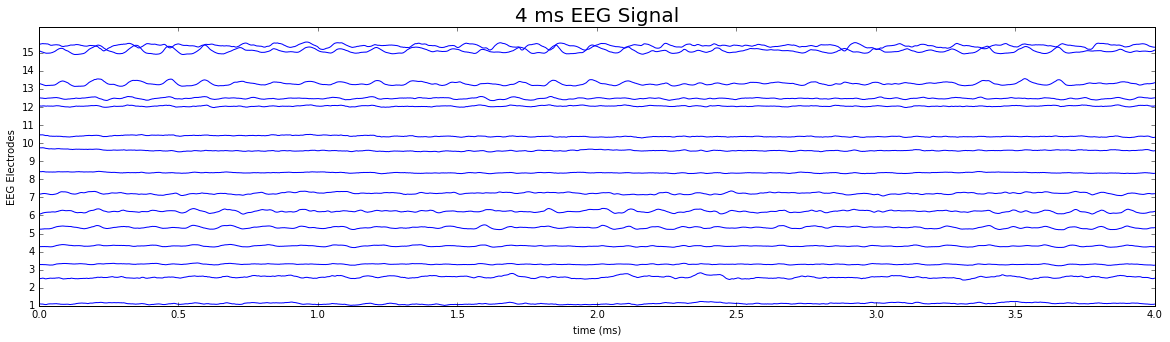

In [138]:
data = eeg[0][:,:20000]
numRows, numSamples = data.shape
print numSamples, numRows
t= np.linspace(0,T,L)
ticklocs = []

fig,ax = plt.subplots(1,1,figsize = (20,5))
ax.set_xlim(0, 4)
#ax.set_xticks(np.arange(10))
dmin = data.min()
dmax = data.max()
dr = (dmax - dmin)*0.7  # Crowd them a bit.
y0 = dmin
y1 = (numRows - 1) * dr + dmax
ax.set_ylim(y0, y1)

segs = []
for i in range(numRows):
    segs.append(np.hstack((t[:, np.newaxis], data[i, :, np.newaxis])))
    ticklocs.append(i*dr)

offsets = np.zeros((numRows, 2), dtype=float)
offsets[:, 1] = ticklocs

lines = LineCollection(segs, offsets=offsets,
                       transOffset=None,
                       )

ax.add_collection(lines)

# set the yticks to use axes coords on the y axis
ax.set_yticks(ticklocs)
ax.set_yticklabels(range(1,16) )

ax.set_xlabel('time (ms)')
ax.set_ylabel('EEG Electrodes')
ax.set_title("4 ms EEG Signal",fontsize = 20)
fig.savefig('EEG Signal.png', format='png', dpi=100)

# Classification

## 1. Try PCA for the classification

In [6]:
#segment the interictal EEG data and apply fourier transform
def segment_interictal_f(folder,seg_length,channel = 0):
    eeg = []
    i = 0 
    upper_lim = 200/5000. * 20000
    for filename in os.listdir(folder):
         if "interictal" in filename:
            path = folder + filename
            i += 1
            struct = sio.loadmat(path, struct_as_record = False, squeeze_me = True) 
            eeg_temp = struct["interictal_segment_" + str(i)].data[channel,:] #read data from first electrode
    
            #segment egg data 
            for seg_index in range(0,len(eeg_temp),seg_length):
                eeg.append(abs(scipy.fftpack.fft(eeg_temp[seg_index:seg_index+seg_length])))#[:upper_lim]) 
                
    
    return np.ravel(eeg).reshape(len(eeg),-1)

In [7]:
#segment the preictal EEG data and apply fourier transform
def segment_preictal_f(folder,seg_length,channel = 0):
    eeg = []
    i = 0 
    upper_lim = 200/5000. * 20000
    for filename in os.listdir(folder):
         if "preictal" in filename:
            path = folder + filename
            i += 1
            struct = sio.loadmat(path, struct_as_record = False, squeeze_me = True) 
            eeg_temp = struct["preictal_segment_" + str(i)].data[channel,:] #read data from first electrode
            
            #segment egg data 
            for seg_index in range(0,len(eeg_temp),seg_length):
                eeg.append(abs(scipy.fftpack.fft(eeg_temp[seg_index:seg_index+seg_length])))#[:upper_lim]) 
    
    return np.ravel(eeg).reshape(len(eeg),-1)

In [8]:
#segment the interictal EEG data
def segment_interictal(folder,seg_length,channel = 0):
    eeg = []
    i = 0 
    upper_lim = 200/5000. * 20000
    for filename in os.listdir(folder):
         if "interictal" in filename:
            path = folder + filename
            i += 1
            struct = sio.loadmat(path, struct_as_record = False, squeeze_me = True) 
            eeg_temp = struct["interictal_segment_" + str(i)].data[channel,:] #read data from first electrode
              
            #segment egg data 
            for seg_index in range(0,len(eeg_temp),seg_length):
                eeg.append(eeg_temp[seg_index:seg_index+seg_length]) 
                
    
    return np.ravel(eeg).reshape(len(eeg),-1)

In [9]:
#segment the preictal EEG data
def segment_preictal(folder,seg_length,channel = 0):
    eeg = []
    i = 0 
    upper_lim = 200/5000. * 20000
    for filename in os.listdir(folder):
         if "preictal" in filename:
            path = folder + filename
            i += 1
            struct = sio.loadmat(path, struct_as_record = False, squeeze_me = True) 
            eeg_temp = struct["preictal_segment_" + str(i)].data[channel,:] #read data from first electrode
            
            #segment egg data 
            for seg_index in range(0,len(eeg_temp),seg_length):
                eeg.append(eeg_temp[seg_index:seg_index+seg_length]) 
    
    return np.ravel(eeg).reshape(len(eeg),-1)

In [10]:
#a function to plot PCA results
def plot_PCA(folder):
    
    for i in range(0,1): #different channels
    
        eeg_normal = segment_interictal(folder,20000,i) #4s a segment
        y_normal = np.zeros(eeg_normal.shape[0])

        eeg_abnormal = segment_preictal(folder,20000,i)
        y_abnormal = np.repeat([1], eeg_abnormal.shape[0])

        egg = np.concatenate((eeg_normal,eeg_abnormal),axis = 0 )
        y = np.concatenate((y_normal,y_abnormal))
        
        #plot PCA
        model = PCA(n_components=2)
        model.fit(egg)
        x_reduced = model.transform(egg)

        #Visualized our reduced data

        plt.scatter(x_reduced[y==0, 0], x_reduced[y==0, 1], c='b', color='b', label='0')
        plt.scatter(x_reduced[y==1, 0], x_reduced[y==1, 1], c='r', color='r', label='1')
        plt.legend()
        plt.show()
        

### PCA results of segmented frequency series. No standardization.

#### frequency domain with 200Hz upper band limit

We have shown earlier that the energy most aggregated within 0-200Hz. It would be better for PCA with more engergy (variance).

In [11]:
eeg_normal = segment_interictal_f(folder,20000) #4s a segment
y_normal = np.zeros(eeg_normal.shape[0])

eeg_abnormal = segment_preictal_f(folder,20000)
y_abnormal = np.repeat([1], eeg_abnormal.shape[0])

egg_f = np.concatenate((eeg_normal,eeg_abnormal),axis = 0 )
y = np.concatenate((y_normal,y_abnormal))

In [12]:
model = PCA(n_components=2)
model.fit(egg_f)
x_reduced_f = model.transform(egg_f)
print "Variance Explained:",model.explained_variance_ratio_

Variance Explained: [ 0.88786104  0.07549518]


The first two principle components already explained about **90%** for the variance. We will try to project our eeg data onto them and evaluate the accuracy.

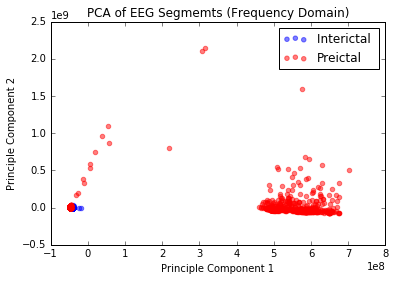

In [15]:
plt.scatter(x_reduced_f[y==0, 0], x_reduced_f[y==0, 1], c='b', color='b', label='Interictal ',alpha=0.5)
plt.scatter(x_reduced_f[y==1, 0], x_reduced_f[y==1, 1], c='r', color='r', label='Preictal',alpha=0.5)
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.title("PCA of EEG Segmemts (Frequency Domain)")
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.legend()
plt.savefig('PCA EEG Freq.png', format='png', dpi=100)

We see the interictal and preictal data are overlapped heavily at the lower left corner and some red some to the right. If we draw a line in between, what is the false negtive rate?

In [18]:
check1 = y[(y==0) & (x_reduced_f[:,0] >  1e8)]
print "mis of interictal:", len(check1)
check2 = y[(y==1) & (x_reduced_f[:,0] <  1e8)]
print "mis of preictal:", len(check2)

print "Misclassification rate (FNR) of preictal: ", len(check2)/float(len(y[y == 1]))

mis of interictal: 0
mis of preictal: 1912
Misclassification rate (FNR) of preictal:  0.708148148148


Wow! The blue dots will be correctly classified but for the red, 70% will be misclassified. **Thus, PCA will not help in the classification problem.** Let's check for time domain.

#### time domain

In [30]:
#load data
interictal = segment_interictal(folder,20000) #4s a segment
y_normal = np.zeros(interictal.shape[0])

preictal = segment_preictal(folder,20000)
y_abnormal = np.repeat([1], preictal.shape[0])

egg = np.concatenate((interictal,preictal),axis = 0 )
y = np.concatenate((y_normal,y_abnormal))

PCA results of segmented time series. No standardization

In [21]:
model = PCA(n_components=3)
model.fit(egg)
x_reduced = model.transform(egg)
print "Variance Explained:",model.explained_variance_ratio_

Variance Explained: [ 0.45331893  0.41932309  0.02392886]


Again, the first two principle components already explained about **86%** for the variance.And the third component drops to 0.02. We will try to project our eeg data onto them and evaluate the accuracy.

In [22]:
model = PCA(n_components=2)
model.fit(egg)
x_reduced = model.transform(egg)
print "Variance Explained:",model.explained_variance_ratio_

Variance Explained: [ 0.45331893  0.41932309]


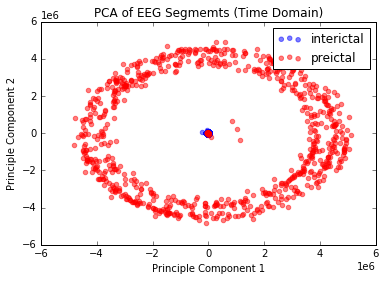

In [23]:
plt.scatter(x_reduced[y==0, 0], x_reduced[y==0, 1], c='b', color='b', label='interictal',alpha=0.5)
plt.scatter(x_reduced[y==1, 0], x_reduced[y==1, 1], c='r', color='r', label='preictal',alpha=0.5)
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.title("PCA of EEG Segmemts (Time Domain)")
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.legend()
plt.savefig('PCA EEG Time.png', format='png', dpi=1000)

It nice circle pops out! We see the interictal and preictal data are overlapped heavily at the center and some red around. If we draw a circle in between, what is the false negtive rate?

In [25]:
check = y[(y==1) & (-200000 < x_reduced[:,0]) &  (x_reduced[:,0] <  20000) & (-200000 < x_reduced[:,1]) &  (x_reduced[:,1] <  20000)]
print "Misclassification rate (FNR) of preictal:", len(check)/float (len(y[y == 1]))

Misclassification rate (FNR) of preictal: 0.702962962963


To conclude, **PCA will not help in the classification problem.** We will further try other approaches such as extracting features.

## 2. Try extracting features for the classification

### a. Comparision

In order to determine what feature to extract and whether it will be helpful, we first try to see the differenct of preictal and interictal EEG signal in both time and frequency domain.

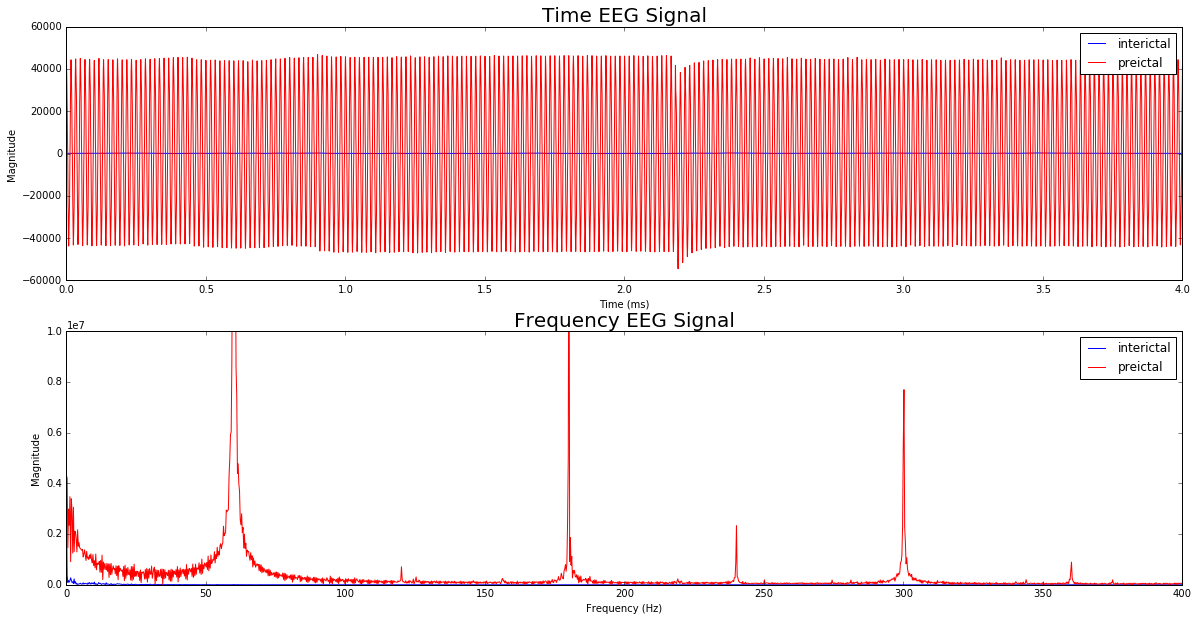

In [163]:
fig,ax = plt.subplots(2,1,figsize = (20,10))
f = np.linspace(0,400,1600)

ax[0].plot(t,egg[0][:],c = "b",label = "interictal")
ax[0].plot(t,egg[8000][:],c = "r",label = "preictal")
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Magnitude")
ax[0].set_title("Time EEG Signal",fontsize = 20)
ax[0].legend(loc = 1)

ax[1].plot(f[:],egg_f[0][:1600],c ="b",label = "interictal")
ax[1].plot(f[:],egg_f[8000][:1600],c ="r",label = "preictal")
ax[1].set_ylim(0,1e7)
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Magnitude")
ax[1].set_title("Frequency EEG Signal",fontsize = 20)
ax[1].legend(loc = 1)

fig.savefig('EEG CMP.png', format='png', dpi=100)

**Observations: ** We plot a typical preictal EEG segment and a typical interictal EEG segment. In the time domian, we see preictal signal shows more **energy and variance**; in the frequency domain, preictal signal also show more **variance and energy** across 0-400 Hz, the magnitude drops after 400Hz (we showed before).

### b. Extract features

We have the features analysis in a separate notebook. After calculating the features, we save them as as .csv file.

### c.Try different models

#### Load data 

In total we have 120 predictors for 15 channels of EEG data, with 8 features for each channel. And we extract them from both **time** domain and **frequency** domain.

Time: 
- Total time energy: Sum of squared magnitude in time domain.
- Time mean (abs): Mean of absolute magnitude of time domain.
- Time variance: Variance of absolute magnitude of time domain.

Frequency: 

- Brightness: Percentage of energy above 25Hz.
- Entropy: We divide the frequency range (0-2.5kHz) into 8 frequency bands. Fundamental requency 0Hz, 0-10Hz, 10-50Hz, 50-100Hz, 100-200Hz, 200-300Hz, 300-400Hz, 400-2500Hz. I both looked at the frequency plot and did several trials and find this division works better in separating the two classes.
- Kurtosis: Fourth standardized moment, https://en.wikipedia.org/wiki/Kurtosis
- Skewness: Third standardized moment, https://en.wikipedia.org/wiki/Skewness
- Frequency Variance: Variance of spectrum magnitude, upper limit = 200Hz

In [9]:
data = pd.read_csv("eeg_patient_1.csv",delimiter=",",low_memory= False)
print data.shape
data.head()

(10200, 120)


,brightness1,entropy1,kurtosis1,mean_time1,skewness1,total_energy_time1,variance_freq1,variance_time1,brightness2,entropy2,...,variance_freq14,variance_time14,brightness15,entropy15,kurtosis15,mean_time15,skewness15,total_energy_time15,variance_freq15,variance_time15
0,0.000880,0.043625,721.094193,158.76020,32.194713,131706224,11856.739156,2751.799696,0.000091,0.006461,...,54871.902462,20660.609164,0.000519,0.036612,764.198325,512.79630,33.570623,-11489614,31048.218837,11742.888406
1,0.001198,0.044445,729.649922,151.27660,32.442783,185629188,11977.381395,2259.838492,0.000086,0.005487,...,51818.693210,13431.091283,0.000585,0.038867,757.598846,491.23910,33.348356,8307888,31946.636490,13221.934631
2,0.001749,0.055361,696.690766,137.54860,31.356172,189459474,12532.309416,2890.508338,0.000112,0.007443,...,48733.568904,8357.453740,0.000549,0.030244,762.664183,454.28490,33.521525,10043944,27632.566455,9652.393232
3,0.007771,0.151379,599.234926,158.35565,28.070734,118714079,20658.297312,7319.352063,0.006053,0.064512,...,47826.564831,9343.361726,0.001381,0.054074,724.933648,340.27445,32.264381,-21545403,27297.634978,12232.118127
4,0.000761,0.034017,722.932694,177.11865,32.271204,61907609,12660.416100,3306.162672,0.000104,0.006273,...,50079.385995,18405.943875,0.000979,0.054537,723.546438,402.08115,32.226772,8140531,31631.492098,16972.757765


In [10]:
#predictors
predictors = data.columns.values
#Response
y = cPickle.load(open('y_patient_1.p', 'rb'))
y

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [11]:
#separate preictal and interictal 
data_no = data.values[:7500,:]
data_yes = data.values[7500:,:]
y_normal = y[y == 0]
y_abnormal = y[y == 1]
print data_no.shape,data_yes.shape

(7500, 120) (2700, 120)


#### Correlation Matrix

We first take a look at the features correlation matrix (take channel 0 for example).

In [12]:
x = data.iloc[:,:8]
x.head()

,brightness1,entropy1,kurtosis1,mean_time1,skewness1,total_energy_time1,variance_freq1,variance_time1
0,0.000880,0.043625,721.094193,158.76020,32.194713,131706224,11856.739156,2751.799696
1,0.001198,0.044445,729.649922,151.27660,32.442783,185629188,11977.381395,2259.838492
2,0.001749,0.055361,696.690766,137.54860,31.356172,189459474,12532.309416,2890.508338
3,0.007771,0.151379,599.234926,158.35565,28.070734,118714079,20658.297312,7319.352063
4,0.000761,0.034017,722.932694,177.11865,32.271204,61907609,12660.416100,3306.162672


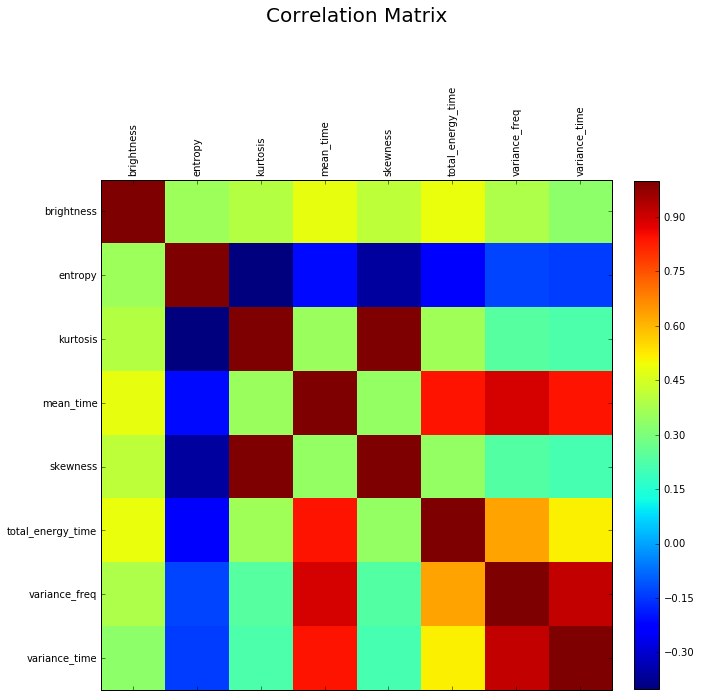

In [181]:
corr = x.corr()
ticklabels = [name[:-1] for name in x.columns.values]
fig, ax = plt.subplots(figsize=(10, 10))
mat = ax.matshow(corr)
plt.xticks(range(len(x.columns)), ticklabels, rotation=90)
plt.yticks(range(len(x.columns)), ticklabels)
ax.set_yticklabels(ticklabels)

plt.title("Correlation Matrix", y=1.3, size=20)
plt.colorbar(mat,fraction=0.0455, pad=0.04)
plt.show()
fig.savefig('Feature Correlation.png', format='png', dpi=100)

**Observation: **Most of the features are not heavily correlated. But we see some obvious correlation between the last three features: total energy in time, variance of spectrum and variance in time and time mean magnitude. We will keep all the features in the modeling  following analysis.

#### Train and test split

70% for training and 30% for testing.

In [13]:
#split train and test for each group
x_train_no, x_test_no, y_train_no, y_test_no = train_test_split(data_no,y_normal,test_size=0.25, random_state=42)
x_train_yes, x_test_yes, y_train_yes, y_test_yes = train_test_split(data_yes,y_abnormal,test_size=0.25, random_state=42)
print x_train_no.shape, x_train_yes.shape

(5625, 120) (2025, 120)


In [14]:
x_train = np.concatenate((x_train_no,x_train_yes),axis = 0)
y_train = np.concatenate((y_train_no,y_train_yes))
x_test = np.concatenate((x_test_no,x_test_yes),axis = 0)
y_test = np.concatenate((y_test_no,y_test_yes))

#### Models and Prediction

- Logistic Regression

In [15]:
#Standardize data
scaler = preprocessing.StandardScaler(with_mean=True, with_std=True).fit(x_train)
x_train_stand = scaler.transform(x_train)
x_test_stand = scaler.transform(x_test)

In [192]:
#tune C and class weight for logistic regression
lg_para = {"C": [np.power(10.,i) for i in np.arange(-4,7,1)], "class_weight": [{1:0.5},{1:1},{1:3},{1:5},{1:7},{1:9}]}

In [191]:
#try a simple model
model = LogReg(C = 100)
model.fit(x_train_stand,y_train)
print "score on testing set, simple logistic regression: ", model.score(x_test_stand,y_test)

score on testing set, simple logistic regression:  0.947843137255


#### Tuning

In [198]:
#visualize grid search

best_c = 0
best_w = 0
best_tpr = 0
average_tprs = np.zeros(((len(lg_para["class_weight"])),len(lg_para["C"])))
average_tnrs = np.zeros(((len(lg_para["class_weight"])),len(lg_para["C"])))

for i,w in enumerate(lg_para["class_weight"]):
    
    for j, c in enumerate(lg_para["C"]):
        # Cross validation for every experiment
        kf = KFold( n_splits=5, shuffle=True)
        k_folds = kf.split(x_train_stand)
        tpr = []
        tnr = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_train_stand[train_indices]
            y_train_cv = y_train[train_indices]
            # Generate validation data
            x_validate = x_train_stand[validation_indices]
            y_validate = y_train[validation_indices]
            
            # Fit random forest on training data
            model = LogReg(C = c, class_weight = w)
            model.fit(x_train_cv, y_train_cv)
            # Score on validation data
            tpr += [model.score(x_validate[y_validate == 1],y_validate[y_validate == 1])]
            tnr += [model.score(x_validate[y_validate == 0],y_validate[y_validate == 0])]
        # Record and report accuracy
        average_tpr = np.mean(tpr)
        average_tnr = np.mean(tnr)
        
        average_tprs[i,j] = average_tpr
        average_tnrs[i,j] = average_tnr

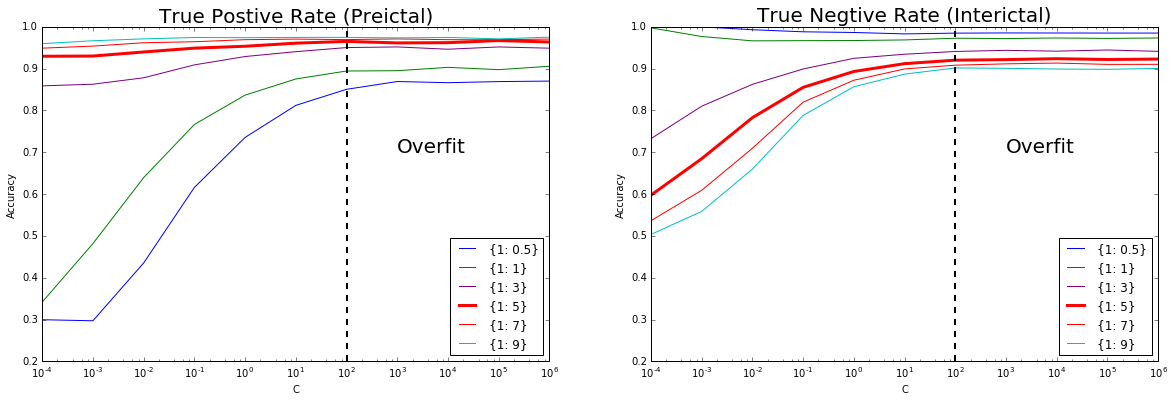

In [236]:
#plot 
fig, ax = plt.subplots(1,2,figsize = (20,6))

#tpr
for i,w in enumerate(lg_para["class_weight"]):
    if w == {1:5}:
        ax[0].semilogx(lg_para["C"], average_tprs[i,:], label= w, linewidth = 3,color = "r")
        ax[1].semilogx(lg_para["C"], average_tnrs[i,:], label= w, linewidth = 3,color = "r")
    elif w == {1:3}:
        ax[0].semilogx(lg_para["C"], average_tprs[i,:], label= w,color = "purple")
        ax[1].semilogx(lg_para["C"], average_tnrs[i,:], label= w,color = "purple")
    else:
        ax[0].semilogx(lg_para["C"], average_tprs[i,:], label= w)
        ax[1].semilogx(lg_para["C"], average_tnrs[i,:], label= w)
        
        
ax[0].text(1000, 0.7,'Overfit',fontsize = 20,color = "k")
ax[1].text(1000, 0.7,'Overfit',fontsize = 20,color = "k")
        
ax[0].axvline(x=100, ymin=0, ymax=1, ls = "--", lw = "2",c = "k")
ax[1].axvline(x=100, ymin=0, ymax=1, ls = "--", lw = "2",c = "k")
        
ax[0].legend(loc = 4)
ax[1].legend(loc = 4)
ax[0].set_ylim(0.2,1)
ax[1].set_ylim(0.2,1)

ax[0].set_title("True Postive Rate (Preictal)",fontsize = 20)
ax[1].set_title("True Negtive Rate (Interictal)",fontsize = 20)
ax[0].set_xlabel("C")
ax[1].set_xlabel("C")
ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Accuracy")

fig.savefig("model/LG_TPR_TNG.png",format = "png",dpi = 100)

From the plot above, we visualize the relationship between tuning  and accuracy of each class. We plot accuracy against different C, with each line representing different class weight. 

As  C increases, the model tends to overfit the training set. And as weights increase, the influence becomes less obvious. In the end we select the thick red line to be our best parameters. While we achieve good accuracy on both classes.

In [237]:
#fit selected "best" model
lg_l2 = LogReg(C=100,class_weight={1:5})
lg_l2.fit(x_train_stand,y_train)
print "train score: ", lg_l2.score(x_train_stand,y_train)
print "test score: ", lg_l2.score(x_test_stand,y_test)

train score:  0.93660130719
test score:  0.934901960784


#### Predicted Probability

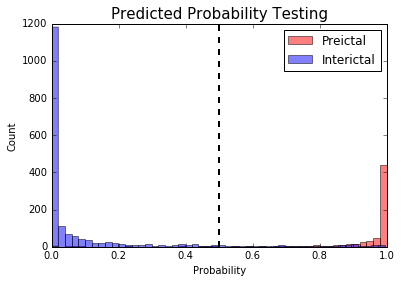

In [244]:
y_pred_lg = lg_l2.predict(x_test_stand)
y_pred_prob_lg = lg_l2.predict_proba(x_test_stand)[:,1]

plt.hist(y_pred_prob_lg[y_test == 1],50,color = "r", alpha = 0.5,label = "Preictal")  
plt.hist(y_pred_prob_lg[y_test == 0],50,color = "b", alpha = 0.5,label = "Interictal")
plt.axvline(x=0.5, ymin=0, ymax=1400, ls = "--", lw = "2",c = "k")
plt.legend(loc = "best")
plt.title("Predicted Probability Testing",fontsize = 15)
plt.xlabel("Probability")
plt.ylabel("Count")
plt.savefig("model/LG_Prob.png",format = "png",dpi = 100)

Also, from predicted probability plot, we see good separation on predicted probability of both interictal and preictal data.

In [284]:
#detailed accuracy
print classification_report(y_test, y_pred_lg, target_names=["interictal","preictal"])

             precision    recall  f1-score   support

 interictal       0.98      0.93      0.95      1875
   preictal       0.82      0.96      0.89       675

avg / total       0.94      0.93      0.94      2550



#### ROC curve

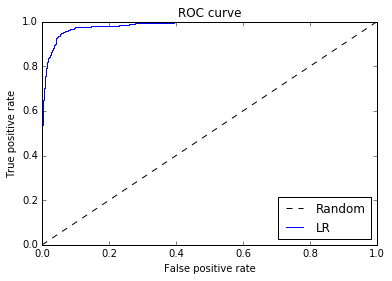

In [245]:
#ROC curve
fpr_lg_l2, tpr_lg_l2, thr = roc_curve(y_test,y_pred_prob_lg)

plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--',label="Random")
plt.plot(fpr_lg_l2, tpr_lg_l2, label='LR')


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Top features

In [246]:
#Top features
coef = lg_l2.coef_[0,:]
#Sort the predictos by coefficient in the dataset
temp = zip(coef , predictors)
top_pred = (sorted(temp, key=lambda t: t[0], reverse=True))[:10]

#Print the predictors
for p in top_pred:
    print p

(25.776256245280425, 'variance_freq9')
(24.899038167550685, 'mean_time1')
(20.946689338120937, 'variance_freq7')
(19.773491973590311, 'mean_time15')
(17.275759456752027, 'mean_time6')
(16.854892039368824, 'total_energy_time14')
(15.497739395180341, 'total_energy_time13')
(15.093187260065857, 'mean_time8')
(14.533292576556692, 'total_energy_time12')
(12.471494593402893, 'variance_freq10')


In [68]:
#visualize
def hist(x_train,y,label,ran,bins):
    index = data.columns.get_loc(label)
    x = x_train[:,index]
    plt.hist(x[y == 1],bins,color = "r", alpha = 0.5,label = "Yes",normed=True,range = ran)  
    plt.hist(x[y == 0],bins,color = "b", alpha = 0.5,label = "No",normed=True,range = ran)
    plt.legend(loc = "best")
    plt.title("Distribution of " + label + " in trainng set" )
    plt.show()


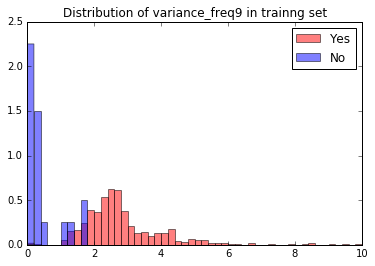

In [69]:
hist(x_train_stand,y_train,"variance_freq9",[0,10],50)

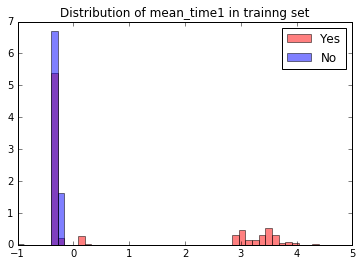

In [74]:
hist(x_train_stand,y_train,"mean_time1",[-1,5],50)

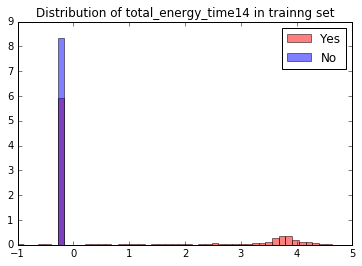

In [75]:
hist(x_train_stand,y_train,"total_energy_time14",[-1,5],50)

The **best predictor** is frequency variance under 200Hz in channel 9.

- Random Forest

In [249]:
rf_para = {"n_estimators": range(1, 40, 2) , "max_depth": range(1, 20, 2)}

#### Tuning

In [255]:
#tune parameters
#visualize grid search
best_c = 0
best_w = 0
best_tpr = 0
average_tprs_rf = np.zeros(((len(rf_para["max_depth"])),len(rf_para["n_estimators"])))
average_tnrs_rf = np.zeros(((len(rf_para["max_depth"])),len(rf_para["n_estimators"])))
for i,w in enumerate(rf_para["max_depth"]):

    for j, c in enumerate(rf_para["n_estimators"]):
        # Cross validation for every experiment
        kf = KFold( n_splits=5, shuffle=True)
        k_folds = kf.split(x_train_stand)
        tpr = []
        tnr = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_train_stand[train_indices]
            y_train_cv = y_train[train_indices]
            # Generate validation data
            x_validate = x_train_stand[validation_indices]
            y_validate = y_train[validation_indices]
            
            # Fit random forest on training data
            model = RF(n_estimators=c, max_depth=w)
            model.fit(x_train_cv, y_train_cv)
            # Score on validation data
            tpr += [model.score(x_validate[y_validate == 1],y_validate[y_validate == 1])]
            tnr += [model.score(x_validate[y_validate == 0],y_validate[y_validate == 0])]
        # Record and report accuracy
        average_tpr = np.mean(tpr)
        average_tnr = np.mean(tnr)
        
        average_tprs_rf[i,j] = average_tpr
        average_tnrs_rf[i,j] = average_tnr
        
#         if (average_tnr >= 0.8) and (average_tpr >= 0.8):
#             print "C:", c, "class_weight:", w, "True Positive Rate: ", average_tpr, "True Negtive Rate: ", average_tnr
#             #get the parameter for highest true positive rate 
#             if average_tpr>best_tpr:
#                 best_tpr = average_tpr
#                 best_c = c
#                 best_w = w
                  
#     #plot tpr of every weight
#     plt.plot(rf_para["n_estimators"], w_c, label= w)

# plt.legend(loc =4)
# plt.title("True Positive Rate")
# plt.show()

# print "best C: ", best_c
# print "best weight", best_w

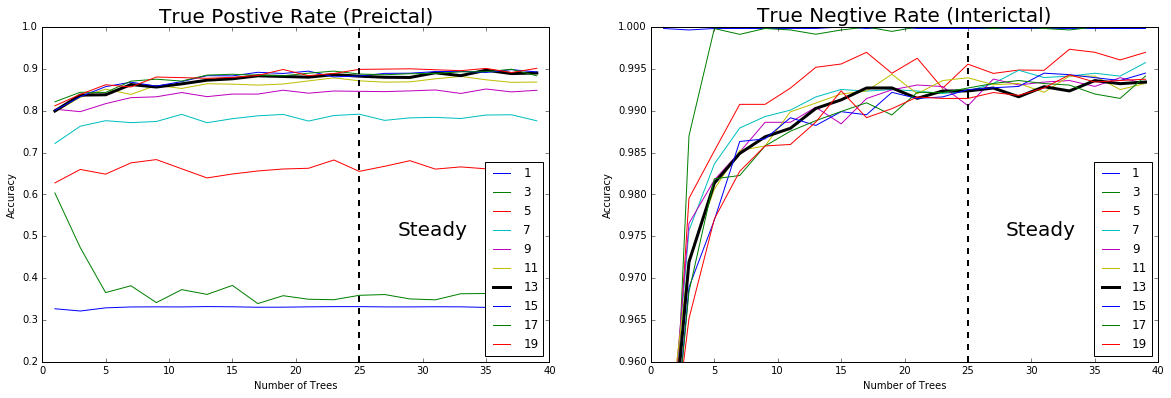

In [268]:
#plot 
fig, ax = plt.subplots(1,2,figsize = (20,6))

#tpr
for i,d in enumerate(rf_para["max_depth"]):
    if d == 13:
        ax[0].plot(rf_para["n_estimators"], average_tprs_rf[i,:], label= d,linewidth = 3)
        ax[1].plot(rf_para["n_estimators"], average_tnrs_rf[i,:], label= d,linewidth = 3)
    else:
        ax[0].plot(rf_para["n_estimators"], average_tprs_rf[i,:], label= d)
        ax[1].plot(rf_para["n_estimators"], average_tnrs_rf[i,:], label= d)

    
        
        
ax[0].text(28, 0.5,'Steady',fontsize = 20,color = "k")
ax[1].text(28, 0.975,'Steady',fontsize = 20,color = "k")
        
ax[0].axvline(x=25, ymin=0, ymax=1, ls = "--", lw = "2",c = "k")
ax[1].axvline(x=25, ymin=0, ymax=1, ls = "--", lw = "2",c = "k")
        
ax[0].legend(loc = 4)
ax[1].legend(loc = 4)
ax[0].set_ylim(0.2,1)
ax[1].set_ylim(0.96,1)

ax[0].set_title("True Postive Rate (Preictal)",fontsize = 20)
ax[1].set_title("True Negtive Rate (Interictal)",fontsize = 20)
ax[0].set_xlabel("Number of Trees")
ax[1].set_xlabel("Number of Trees")
ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Accuracy")

fig.savefig("model/RF_TPR_TNG.png",format = "png",dpi = 100)

From the plot above, we visualize the relationship between tuning  and accuracy of each class. We plot accuracy against different number of trees, with each line representing different maximum depth. 

As  n_estimator increases, the accuracy becomes steady (can not reduce variance more by combining more trees) . And as maximum depth increase, the influence becomes less obvious. In the end we select the **thick black line** to be our best parameters. While we achieve good accuracy on both classes

In [349]:
#fit our "best" model
rf = RF(n_estimators=25,max_depth=13)
rf.fit(x_train_stand,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Predicted Probability

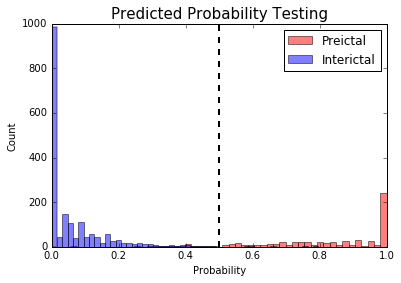

In [350]:
y_pred_rf = rf.predict(x_test_stand)
y_pred_prob_rf = rf.predict_proba(x_test_stand)[:,1]

plt.figure(1)
plt.hist(y_pred_prob_rf[y_test == 1],50,color = "r", alpha = 0.5,label = "Preictal")  
plt.hist(y_pred_prob_rf[y_test == 0],50,color = "b", alpha = 0.5,label = "Interictal")
plt.axvline(x=0.5, ymin=0, ymax=1400, ls = "--", lw = "2",c = "k")
plt.legend(loc = "best")
plt.title("Predicted Probability Testing",fontsize = 15)
plt.xlabel("Probability")
plt.ylabel("Count")
plt.savefig("model/RF_Prob.png",format = "png",dpi = 100)

In [351]:
#Detailed Accuracy
print classification_report(y_test, y_pred_rf, target_names=["interictal","preictal"])

             precision    recall  f1-score   support

 interictal       0.97      0.99      0.98      1875
   preictal       0.98      0.91      0.94       675

avg / total       0.97      0.97      0.97      2550



#### ROC curve

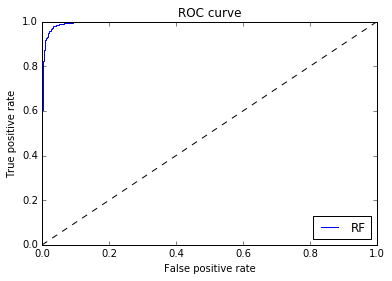

In [352]:
#ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)

plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Top features

In [354]:
#Top features
coef_rf = rf.feature_importances_
#Sort the predictos by coefficient in the dataset
temp = zip(coef_rf , predictors)
top_pred = (sorted(temp, key=lambda t: t[0], reverse=True))[:10]

#Print the predictors
for p in top_pred:
    print p

(0.056748303433050609, 'variance_freq15')
(0.046999534111442698, 'variance_time15')
(0.035753468627471641, 'mean_time3')
(0.033954987327237444, 'total_energy_time8')
(0.032697620647557511, 'mean_time7')
(0.0250903490476585, 'mean_time6')
(0.023565674782752146, 'mean_time8')
(0.02249932494871687, 'total_energy_time11')
(0.019408082155517835, 'variance_freq7')
(0.018881469023184164, 'mean_time9')


**Observations: ** The top three predictors we find from logistic regression and random forest are:
**frequency variance, time mean magnitude and total time energy**. These predictors are highly correlated from the correlation matrix.


- Gradient Boost

In [58]:
gb_para = {"n_estimators": np.arange(100,400,100) , "max_depth": range(1, 5)}

#### Tuning

In [1]:
#function for grid search
def grid(x, y, model, param_grid, n_folds, scoring="roc_auc"):
    gs = GridSearchCV(model, param_grid=param_grid, cv=n_folds, scoring=scoring)
    gs.fit(x,y)
    return gs.best_estimator_

In [59]:
gb = GDB()
gb_gs = grid(x_train_stand,y_train, gb, gb_para, 5, scoring='f1')
gb_gs.fit(x_train_stand,y_train)
print "train score: ", gb_gs.score(x_train_stand,y_train)
print "test score: ", gb_gs.score(x_test_stand,y_test)
print "gb best para:",gb_gs

train score:  1.0
test score:  0.973725490196
rf best para: GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [278]:
gb = GDB(max_depth=4,n_estimators=300)
gb.fit(x_train_stand,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [279]:
gb.score(x_test_stand,y_test)

0.97607843137254902

#### Predicted probability

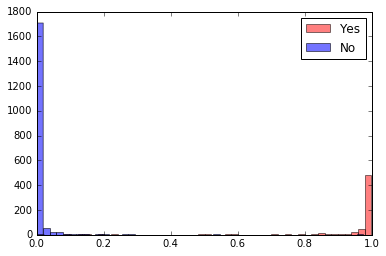

In [285]:
y_pred_gb = gb.predict(x_test_stand)
y_pred_prob_gb = gb.predict_proba(x_test_stand)[:,1]

plt.figure(1)
plt.hist(y_pred_prob_gb[y_test == 1],50,color = "r", alpha = 0.5,label = "Yes")  
plt.hist(y_pred_prob_gb[y_test == 0],50,color = "b", alpha = 0.55,label = "No")
plt.legend(loc = "best")
plt.show()

In [287]:
print classification_report(y_test, y_pred_gb, target_names=["interictal","preictal"])

             precision    recall  f1-score   support

 interictal       0.98      0.99      0.98      1875
   preictal       0.97      0.94      0.95       675

avg / total       0.98      0.98      0.98      2550



In [ ]:
gb2 = GDB(max_depth=4,n_estimators=300)
gb2.fit(x_train_stand,y_train)

#### ROC curve

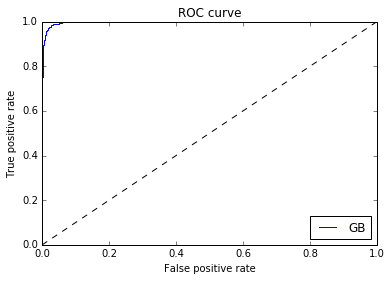

In [286]:
#ROC curve
fpr_gb, tpr_gb, thres = roc_curve(y_test, y_pred_prob_gb)

plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gb, tpr_gb, label='GB')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

- LDA

In [295]:
lda_para = {"priors": [[0.1,0.9],[0.3,0.7],[0.5,0.5],[0.7,0.3],[0.9,0.1]]}

In [292]:
model = LDA(priors = [0.1,0.9])
model.fit(x_train_stand,y_train)
model.score(x_test_stand,y_test)

0.8631372549019608

#### Tuning

In [296]:
#tune parameters
#visualize grid search
best_c = 0
best_w = 0
best_tpr = 0
average_tprs_rf = np.zeros(len(lda_para["priors"]))
average_tnrs_rf = np.zeros(len(lda_para["priors"]))
for i,w in enumerate(lda_para["priors"]):
    # Cross validation for every experiment
    kf = KFold( n_splits=5, shuffle=True)
    k_folds = kf.split(x_train_stand)
    tpr = []
    tnr = []
    for train_indices, validation_indices in k_folds:
        # Generate training data
        x_train_cv = x_train_stand[train_indices]
        y_train_cv = y_train[train_indices]
        # Generate validation data
        x_validate = x_train_stand[validation_indices]
        y_validate = y_train[validation_indices]

        # Fit random forest on training data
        model = LDA(priors=w)
        model.fit(x_train_cv, y_train_cv)
        # Score on validation data
        tpr += [model.score(x_validate[y_validate == 1],y_validate[y_validate == 1])]
        tnr += [model.score(x_validate[y_validate == 0],y_validate[y_validate == 0])]
    # Record and report accuracy
    average_tpr = np.mean(tpr)
    average_tnr = np.mean(tnr)

    average_tprs_rf[i] = average_tpr
    average_tnrs_rf[i] = average_tnr

In [297]:
average_tprs_rf

array([ 0.95897675,  0.92681577,  0.88779615,  0.83474754,  0.72895916])

In [298]:
average_tnrs_rf

array([ 0.83701169,  0.91894512,  0.94853829,  0.96768044,  0.98634119])

We choose priors to be [0.3,0.7] because we want accuracy on both classes to be more than **90%**.

In [299]:
lda = LDA(priors=[0.3,0.7])
lda.fit(x_train_stand,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=[0.3, 0.7],
              shrinkage=None, solver='svd', store_covariance=False,
              tol=0.0001)

#### Predicted Probability

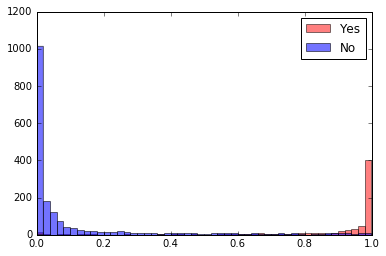

In [300]:
y_pred_lda = lda.predict(x_test_stand)
y_pred_prob_lda = lda.predict_proba(x_test_stand)[:,1]

plt.hist(y_pred_prob_lda[y_test == 1],50,color = "r", alpha = 0.5,label = "Yes")  
plt.hist(y_pred_prob_lda[y_test == 0],50,color = "b", alpha = 0.55,label = "No")
plt.legend(loc = "best")
plt.show()

In [301]:
print classification_report(y_test, y_pred_lda, target_names=["interictal","preictal"])

             precision    recall  f1-score   support

 interictal       0.97      0.91      0.94      1875
   preictal       0.79      0.93      0.85       675

avg / total       0.92      0.91      0.92      2550



#### ROC curve

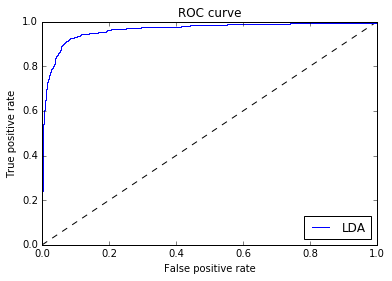

In [302]:
#ROC curve
fpr_lda, tpr_lda, thres = roc_curve(y_test, y_pred_prob_lda)

plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lda, tpr_lda, label='LDA')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

- QDA

In [306]:
qda_para = {"priors": [[0.1,0.9],[0.3,0.7],[0.5,0.5],[0.7,0.3],[0.9,0.1]]}

In [304]:
model = QDA(priors = [0.1,0.9])
model.fit(x_train_stand,y_train)
model.score(x_test_stand,y_test)

0.82196078431372555

#### Tuning

In [307]:
#tune parameters
#visualize grid search
best_c = 0
best_w = 0
best_tpr = 0
average_tprs_qda = np.zeros(len(qda_para["priors"]))
average_tnrs_qda = np.zeros(len(qda_para["priors"]))
for i,w in enumerate(qda_para["priors"]):
    # Cross validation for every experiment
    kf = KFold( n_splits=5, shuffle=True)
    k_folds = kf.split(x_train_stand)
    tpr = []
    tnr = []
    for train_indices, validation_indices in k_folds:
        # Generate training data
        x_train_cv = x_train_stand[train_indices]
        y_train_cv = y_train[train_indices]
        # Generate validation data
        x_validate = x_train_stand[validation_indices]
        y_validate = y_train[validation_indices]

        # Fit random forest on training data
        model = QDA(priors=w)
        model.fit(x_train_cv, y_train_cv)
        # Score on validation data
        tpr += [model.score(x_validate[y_validate == 1],y_validate[y_validate == 1])]
        tnr += [model.score(x_validate[y_validate == 0],y_validate[y_validate == 0])]
    # Record and report accuracy
    average_tpr = np.mean(tpr)
    average_tnr = np.mean(tnr)

    average_tprs_qda[i] = average_tpr
    average_tnrs_qda[i] = average_tnr
        
#         if (average_tnr >= 0.8) and (average_tpr >= 0.8):
#             print "C:", c, "class_weight:", w, "True Positive Rate: ", average_tpr, "True Negtive Rate: ", average_tnr
#             #get the parameter for highest true positive rate 
#             if average_tpr>best_tpr:
#                 best_tpr = average_tpr
#                 best_c = c
#                 best_w = w
                  
#     #plot tpr of every weight
#     plt.plot(rf_para["n_estimators"], w_c, label= w)

# plt.legend(loc =4)
# plt.title("True Positive Rate")
# plt.show()

# print "best C: ", best_c
# print "best weight", best_w

In [308]:
average_tprs_qda

array([ 0.3374101 ,  0.33838991,  0.33693473,  0.33582727,  0.33625884])

In [309]:
average_tnrs_qda

array([ 0.99376125,  0.99325579,  0.99290427,  0.99359224,  0.99342501])

We choose priors to be [0.3,0.7] because we want accuracy on both classes to be more than as high as possible.

In [310]:
qda = QDA(priors=[0.3,0.7])
qda.fit(x_train_stand,y_train)

QuadraticDiscriminantAnalysis(priors=array([ 0.3,  0.7]), reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [320]:
y_pred_qda = qda.predict(x_test_stand)
y_pred_prob_qda = qda.predict_proba(x_test_stand)[:,1]

In [321]:
print classification_report(y_test, y_pred_qda, target_names=["interictal","preictal"])

             precision    recall  f1-score   support

 interictal       0.81      1.00      0.89      1875
   preictal       0.96      0.34      0.50       675

avg / total       0.85      0.82      0.79      2550



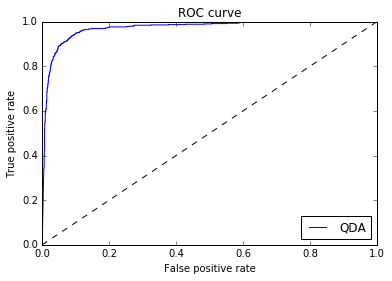

In [322]:
#ROC curve
fpr_qda, tpr_qda, thres = roc_curve(y_test, y_pred_prob_qda)

plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_qda, tpr_qda, label='QDA')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

- KNN

In [326]:
knn_para = {"n_neighbors": range(1,10,2)}

In [324]:
model = KNN()
model.fit(x_train_stand,y_train)
model.score(x_test_stand,y_test)

0.9223529411764706

#### Tuning

In [327]:
#tune parameters
#visualize grid search
best_c = 0
best_w = 0
best_tpr = 0
average_tprs_knn = np.zeros(len(knn_para["n_neighbors"]))
average_tnrs_knn = np.zeros(len(knn_para["n_neighbors"]))
for i,w in enumerate(knn_para["n_neighbors"]):
    # Cross validation for every experiment
    kf = KFold( n_splits=5, shuffle=True)
    k_folds = kf.split(x_train_stand)
    tpr = []
    tnr = []
    for train_indices, validation_indices in k_folds:
        # Generate training data
        x_train_cv = x_train_stand[train_indices]
        y_train_cv = y_train[train_indices]
        # Generate validation data
        x_validate = x_train_stand[validation_indices]
        y_validate = y_train[validation_indices]

        # Fit random forest on training data
        model = KNN(n_neighbors=w)
        model.fit(x_train_cv, y_train_cv)
        # Score on validation data
        tpr += [model.score(x_validate[y_validate == 1],y_validate[y_validate == 1])]
        tnr += [model.score(x_validate[y_validate == 0],y_validate[y_validate == 0])]
    # Record and report accuracy
    average_tpr = np.mean(tpr)
    average_tnr = np.mean(tnr)

    average_tprs_knn[i] = average_tpr
    average_tnrs_knn[i] = average_tnr

In [328]:
average_tprs_knn

array([ 0.81031874,  0.80752315,  0.79038637,  0.78795676,  0.78217744])

In [329]:
average_tnrs_knn

array([ 0.95207017,  0.96109242,  0.96536219,  0.96247405,  0.96689002])

Best parameters to be n_neighbors = 1. 

In [330]:
knn = KNN(n_neighbors=1)
knn.fit(x_train_stand,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [331]:
y_pred_knn = knn.predict(x_test_stand)
y_pred_prob_knn = knn.predict_proba(x_test_stand)[:,1]

#### Accuracy

In [332]:
print classification_report(y_test, y_pred_knn, target_names=["interictal","preictal"])

             precision    recall  f1-score   support

 interictal       0.94      0.96      0.95      1875
   preictal       0.88      0.84      0.86       675

avg / total       0.93      0.93      0.93      2550



### Compare different models

We successively run logistic regression, random forest, LDA, QDA, KNN, and boosting and tuned the best parameters on the training set. Now we compare the ROC curve of these models. 

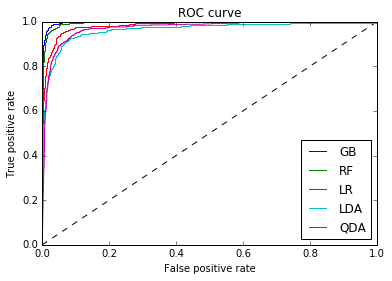

In [338]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gb, tpr_gb, label='GB')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_lg_l2, tpr_lg_l2, label='LR')
plt.plot(fpr_lda, tpr_lda, label='LDA')
plt.plot(fpr_qda, tpr_qda, label='QDA')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("model/ROC1.png",format = "png",dpi = 100)

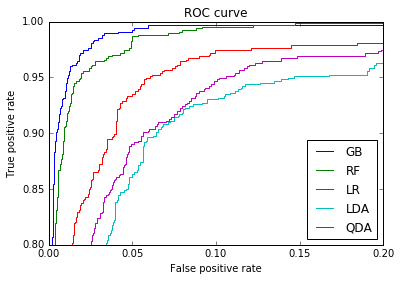

In [339]:
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gb, tpr_gb, label='GB')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_lg_l2, tpr_lg_l2, label='LR')
plt.plot(fpr_lda, tpr_lda, label='LDA')
plt.plot(fpr_qda, tpr_qda, label='QDA')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("model/ROC2.png",format = "png",dpi = 100)

All the models are doing really good job. The best model is boosting. The ROC curve hang to the upper left corner, achieving both highest true positive rate and lowest false positive rate. 

### Conclusion 
So far, using the features we extracted from both interictal and preictal EEG signal of the same patient, we have achieved, at highest, total classification accuracy of 0.98, with 0.97 accuracy on preictal data and 0.98 accuracy on interictal data. 

### Further Work
If we can have access to EEG data from many more different features, we can try to give a general seizure forecast metric. Also, we can explore on extracting more features from the EEG signal.